# Quickstart Example with Off-Policy Learners
---
This notebook provides an example of implementing several off-policy learning methods with synthetic logged bandit data.

The example consists of the following four major steps:
- (1) Generating Synthetic Data
- (2) Off-Policy Learning
- (3) Evaluation of Off-Policy Learners

Please see [../examples/opl](../opl) for a more sophisticated example of the evaluation of off-policy learners with synthetic bandit data.

In [1]:
# QUESTIONS:
# 1. WHY THE LO_PROB WHILE CALCULATING IN OFFLINE.PY
# 2. IS THE DENOMINATOR CALCULATION CORRECT??

In [2]:
# needed when using Google Colab
# !pip install obp


In [3]:
from sklearn.ensemble import RandomForestClassifier as RandomForest
from sklearn.linear_model import LogisticRegression
import sys
import numpy as np
import torch
#sys.path.append ('/Users/tanvikapoor/zr-obp')
print(sys.path)

# import open bandit pipeline (obp)
import obp
from obp.dataset import (
    SyntheticBanditDataset,
    logistic_reward_function,
    linear_reward_function
)
from obp.policy import (
    IPWLearner, 
    QLearner,
    NNPolicyLearner, 
    Random
)

['/Users/tanvikapoor/zr-obp/examples/quickstart', '/Users/tanvikapoor/.vscode/extensions/ms-toolsai.jupyter-2021.8.1236758218/pythonFiles/vscode_datascience_helpers', '/Users/tanvikapoor/.vscode/extensions/ms-toolsai.jupyter-2021.8.1236758218/pythonFiles', '/Users/tanvikapoor/.vscode/extensions/ms-toolsai.jupyter-2021.8.1236758218/pythonFiles/lib/python', '/Users/tanvikapoor/opt/anaconda3/lib/python38.zip', '/Users/tanvikapoor/opt/anaconda3/lib/python3.8', '/Users/tanvikapoor/opt/anaconda3/lib/python3.8/lib-dynload', '', '/Users/tanvikapoor/.local/lib/python3.8/site-packages', '/Users/tanvikapoor/opt/anaconda3/lib/python3.8/site-packages', '/Users/tanvikapoor/opt/anaconda3/lib/python3.8/site-packages/aeosa', '/Users/tanvikapoor/opt/anaconda3/lib/python3.8/site-packages/obp-0.5.2-py3.8.egg', '/Users/tanvikapoor/opt/anaconda3/lib/python3.8/site-packages/pingouin-0.5.1-py3.8.egg', '/Users/tanvikapoor/opt/anaconda3/lib/python3.8/site-packages/pyieoe-0.1.1-py3.8.egg', '/Users/tanvikapoor/op

In [4]:
# obp version
print(obp.__version__)

0.5.2


## (1) Generating Synthetic Data
`obp.dataset.SyntheticBanditDataset` is an easy-to-use synthetic data generator.

It takes 
- number of actions (`n_actions`, $|\mathcal{A}|$)
- dimension of context vectors (`dim_context`, $d$)
- reward function (`reward_function`, $q(x,a)=\mathbb{E}[r|x,a]$)

as inputs and generates synthetic logged bandit data that can be used to evaluate the performance of decision making policies (obtained by `off-policy learning`).

In [5]:
# generate synthetic logged bandit data with 10 actions
# we use `logistic function` as the reward function and control the behavior policy with `beta`
# one can define their own reward function and behavior policy function such as nonlinear ones. 
dataset = SyntheticBanditDataset(
    n_actions=10,
    dim_context=5,
    beta=-2, # inverse temperature parameter to control the optimality and entropy of the behavior policy
    reward_type="binary", # "binary" or "continuous"
    reward_function=logistic_reward_function,
    random_state=12345,
)

In [6]:
# obtain training and test sets of synthetic logged bandit data
n_rounds_train, n_rounds_test = 10000, 10000
bandit_feedback_train = dataset.obtain_batch_bandit_feedback(n_rounds=n_rounds_train)
bandit_feedback_test = dataset.obtain_batch_bandit_feedback(n_rounds=n_rounds_test)

the logged bandit dataset is collected by the behavior policy as follows.

$ \mathcal{D}_b := \{(x_i,a_i,r_i)\}_{i=1}^n$  where $(x,a,r) \sim p(x)\pi_b(a | x)p(r | x,a) $

In [7]:
# `bandit_feedback` is a dictionary storing synthetic logged bandit data
bandit_feedback_train

{'n_rounds': 10000,
 'n_actions': 10,
 'context': array([[-0.20470766,  0.47894334, -0.51943872, -0.5557303 ,  1.96578057],
        [ 1.39340583,  0.09290788,  0.28174615,  0.76902257,  1.24643474],
        [ 1.00718936, -1.29622111,  0.27499163,  0.22891288,  1.35291684],
        ...,
        [-1.27028221,  0.80914602, -0.45084222,  0.47179511,  1.89401115],
        [-0.68890924,  0.08857502, -0.56359347, -0.41135069,  0.65157486],
        [ 0.51204121,  0.65384817, -1.98849253, -2.14429131, -0.34186901]]),
 'action_context': array([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1]]),
 'action': array([9, 2, 1, ..., 0, 3, 7]),
 'position': None,
 're

In [8]:
bandit_feedback_test

{'n_rounds': 10000,
 'n_actions': 10,
 'context': array([[ 0.43473651,  0.28892246, -0.80945479,  1.59442032,  0.86886285],
        [ 0.40338143, -0.47894608, -0.06737703, -2.65932054, -0.83837731],
        [ 2.47244458,  0.59674369,  0.61911426, -0.20459904,  0.14098079],
        ...,
        [ 1.42408759,  0.43832029,  1.60780305, -0.27684065, -1.41350158],
        [-0.65257593, -1.4938017 , -0.66387424,  0.68710758, -1.25823339],
        [-1.02877579,  0.40254317, -0.24025777,  0.22296652, -1.10929397]]),
 'action_context': array([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1]]),
 'action': array([9, 4, 1, ..., 0, 2, 7]),
 'position': None,
 're

## (2) Off-Policy Learning
After generating synthetic data, we now train some decision making policies.

To train policies on logged bandit data, we use

- `obp.policy.NNPolicyLearner` (Neural Network Policy Learner)
- `obp.policy.IPWLearner`

For `NN Learner`, we use 
- Direct Method ("dm")
- InverseProbabilityWeighting ("ipw")
- DoublyRobust ("dr") 

as its objective functions (`off_policy_objective`). 

For `IPW Learner`, we use `RandomForestClassifier` and *LogisticRegression* implemented in scikit-learn for base ML methods.

A policy is trained by maximizing an OPE estimator as an objective function as follows.

$$ \hat{\pi} \in \arg \max_{\pi \in \Pi} \hat{V} (\pi; \mathcal{D}_{tr}) - \lambda \cdot \Omega (\pi)  $$

where $\hat{V}(\cdot; \mathcal{D})$ is an off-policy objective and $\mathcal{D}_{tr}$ is a training bandit dataset. $\Omega (\cdot)$ is a regularization term.

In [9]:
# # define NNPolicyLearner with DM as its objective function
# nn_dm = NNPolicyLearner(
#     n_actions=dataset.n_actions,
#     dim_context=dataset.dim_context,
#     off_policy_objective="dm",
#     batch_size=64,
#     random_state=12345,
# )

# # train NNPolicyLearner on the training set of logged bandit data
# nn_dm.fit(
#     context=bandit_feedback_train["context"],
#     action=bandit_feedback_train["action"],
#     reward=bandit_feedback_train["reward"],
# )

# # obtains action choice probabilities for the test set
# action_dist_nn_dm = nn_dm.predict_proba(
#     context=bandit_feedback_test["context"]
# )

In [10]:
# define NNPolicyLearner with IPW as its objective function

num_lst_test = []
den_lst_test = []
ratio_lst_test = []
num_lst_train = []
den_lst_train = []
ratio_lst_train = []

def graph_values (pred_actions, action, pscore, rewards):
        idx_tensor = torch.arange(action.shape[0], dtype=torch.long)
        iw = pred_actions[idx_tensor, action] / pscore
        num = np.mean(iw * rewards)
        den = np.mean(iw)
        ratio = num/den
        return num, den, ratio

for l in np.arange(0,1.1,0.1): 
    nn_ipw = NNPolicyLearner(
        n_actions=dataset.n_actions,
        dim_context=dataset.dim_context,
        off_policy_objective="ipw",
        batch_size=64,
        random_state=12345,
        loss_translation = l
    )

    # train NNPolicyLearner on the training set of logged bandit data
    nn_ipw.fit(
        context=bandit_feedback_train["context"],
        action=bandit_feedback_train["action"],
        reward=bandit_feedback_train["reward"],
        pscore=bandit_feedback_train["pscore"],
    )

    # obtains action choice probabilities for the test set
    action_dist_nn_ipw_test = nn_ipw.predict_proba(
        context=bandit_feedback_test["context"]
    )

    pred_actions_test = action_dist_nn_ipw_test [:,:,0]
    action_test = bandit_feedback_test["action"]
    pscore_test = bandit_feedback_test["pscore"]
    rewards_test = bandit_feedback_test["reward"]

    num_test, den_test, ratio_test = graph_values (pred_actions_test, action_test, pscore_test, rewards_test)
    num_lst_test.append(num_test)
    den_lst_test.append(den_test)
    ratio_lst_test.append(ratio_test)
    print(num_test, den_test, ratio_test)

    action_dist_nn_ipw_train = nn_ipw.predict_proba(
        context=bandit_feedback_train["context"]
    )

    pred_actions_train = action_dist_nn_ipw_train [:,:,0]
    action_train = bandit_feedback_train["action"]
    pscore_train = bandit_feedback_train["pscore"]
    rewards_train = bandit_feedback_train["reward"]

    num_train, den_train, ratio_train = graph_values (pred_actions_train, action_train, pscore_train, rewards_train)
    num_lst_train.append(num_train)
    den_lst_train.append(den_train)
    ratio_lst_train.append(ratio_train)


policy learning:   0%|          | 0/200 [00:00<?, ?it/s]

[1 0 0 ... 0 0 1]
[ 0.5 -0.5 -0.5 ... -0.5 -0.5  0.5]
Here


policy learning:   0%|          | 0/200 [00:00<?, ?it/s]

0.7592709473199616 0.9989264890185606 0.7600869089635823
[1 0 0 ... 0 0 1]
[ 0.5 -0.5 -0.5 ... -0.5 -0.5  0.5]
Here


policy learning:   0%|          | 0/200 [00:00<?, ?it/s]

0.7605003429974979 1.0011894237360213 0.7595968604618574
[1 0 0 ... 0 0 1]
[ 0.5 -0.5 -0.5 ... -0.5 -0.5  0.5]
Here


policy learning:   0%|          | 0/200 [00:00<?, ?it/s]

0.7619300315045386 1.0027469477894313 0.7598427830513205
[1 0 0 ... 0 0 1]
[ 0.5 -0.5 -0.5 ... -0.5 -0.5  0.5]
Here


policy learning:   0%|          | 0/200 [00:00<?, ?it/s]

0.7627806003100935 1.0040469312581686 0.7597061218585223
[1 0 0 ... 0 0 1]
[ 0.5 -0.5 -0.5 ... -0.5 -0.5  0.5]
Here


policy learning:   0%|          | 0/200 [00:00<?, ?it/s]

0.7635230924156466 1.0042344528366256 0.7603036225842978
[1 0 0 ... 0 0 1]
[ 0.5 -0.5 -0.5 ... -0.5 -0.5  0.5]
Here


policy learning:   0%|          | 0/200 [00:00<?, ?it/s]

0.7645549710917013 1.004073511698654 0.7614531826442227
[1 0 0 ... 0 0 1]
[ 0.5 -0.5 -0.5 ... -0.5 -0.5  0.5]
Here


policy learning:   0%|          | 0/200 [00:00<?, ?it/s]

0.765409892936603 1.0038550432716364 0.7624705360268715
[1 0 0 ... 0 0 1]
[ 0.5 -0.5 -0.5 ... -0.5 -0.5  0.5]
Here


policy learning:   0%|          | 0/200 [00:00<?, ?it/s]

0.7648385119277056 1.003434699416066 0.7622205135748167
[1 0 0 ... 0 0 1]
[ 0.5 -0.5 -0.5 ... -0.5 -0.5  0.5]
Here


policy learning:   0%|          | 0/200 [00:00<?, ?it/s]

0.7638935402411391 1.002112866597193 0.762282938083652
[1 0 0 ... 0 0 1]
[ 0.5 -0.5 -0.5 ... -0.5 -0.5  0.5]
Here


policy learning:   0%|          | 0/200 [00:00<?, ?it/s]

0.7708756158751785 1.008204027229571 0.7646027937355659
[1 0 0 ... 0 0 1]
[ 0.5 -0.5 -0.5 ... -0.5 -0.5  0.5]
Here


policy learning: 100%|██████████| 200/200 [01:08<00:00,  2.92it/s]

0.7562755523650166 0.9921484334419409 0.7622604913474097


In [11]:
# Numerator, Denominator, Ratio : 
# loss = 0 -> 0.7592709473199616 0.9989264890185606 0.7600869089635823
# loss = 0.1 -> 0.7605003429974979 1.0011894237360213 0.7595968604618574
# loss = 0.2 -> 0.7619300315045386 1.0027469477894313 0.7598427830513205
# loss = 0.3 -> 0.7627806003100935 1.0040469312581686 0.7597061218585223
# loss = 0.4 -> 0.7635230924156466 1.0042344528366256 0.7603036225842978
# loss = 0.5 -> 0.7645549710917013 1.004073511698654 0.7614531826442227
# loss = 0.6 -> 0.765409892936603 1.0038550432716364 0.7624705360268715
# loss = 0.7 -> 0.7648385119277056 1.003434699416066 0.7622205135748167
# loss = 0.8 -> 0.7638935402411391 1.002112866597193 0.762282938083652
# loss = 0.9 -> 0.7708756158751785 1.008204027229571 0.7646027937355659
# loss = 1 -> 0.7562755523650166 0.9921484334419409 0.7622604913474097

<ipython-input-72-38c2330adaa7>:26: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


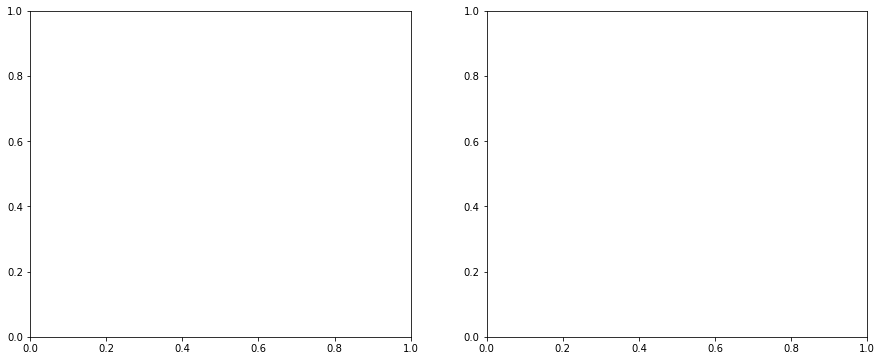

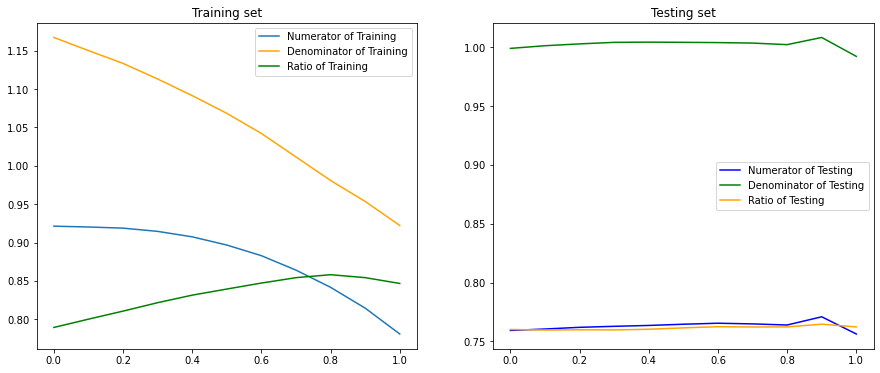

In [72]:
import matplotlib.pyplot as plt

loss = np.arange(0, 1.1, 0.1)

fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(15, 6))

#loss = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
ax1.plot (loss, num_lst_train, label = "Numerator of Training")

ax1.plot (loss, den_lst_train, label = "Denominator of Training", color = "orange")

ax1.plot (loss, ratio_lst_train, label = "Ratio of Training", color = "green")
ax1.legend()
ax1.set_title ("Training set")

ax2.plot (loss, num_lst_test, label = "Numerator of Testing", color = "blue")

ax2.plot (loss, den_lst_test, label = "Denominator of Testing", color = "green")

ax2.plot (loss, ratio_lst_test, label = "Ratio of Testing", color = "orange")
ax2.legend()
ax2.set_title ("Testing set")
fig.show()



<ipython-input-71-f082d8c6a6e2>:38: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


<Figure size 1080x432 with 0 Axes>

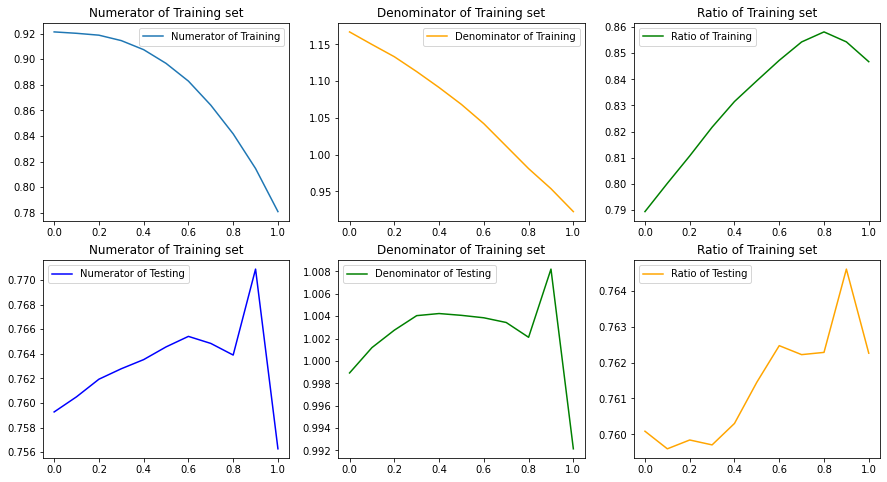

<Figure size 1080x432 with 0 Axes>

In [71]:
import matplotlib.pyplot as plt

loss = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]

fig = plt.figure(figsize=(15, 6))
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2,3,figsize=(15, 8))
plt.figure(figsize=(15, 6))
# ax1 = fig.add_subplot(111)
# ax2 = fig.add_subplot(121)
# ax3 = fig.add_subplot(211)
# ax4 = fig.add_subplot(221)
# ax5 = fig.add_subplot(311)
# ax6 = fig.add_subplot(321)

ax1.plot (loss, num_lst_train, label = "Numerator of Training")
ax1.legend()
ax1.set_title ("Numerator of Training set")

ax2.plot (loss, den_lst_train, label = "Denominator of Training", color = "orange")
ax2.legend()
ax2.set_title ("Denominator of Training set")

ax3.plot (loss, ratio_lst_train, label = "Ratio of Training", color = "green")
ax3.legend()
ax3.set_title ("Ratio of Training set")

ax4.plot (loss, num_lst_test, label = "Numerator of Testing", color = "blue")
ax4.legend()
ax4.set_title ("Numerator of Training set")

ax5.plot (loss, den_lst_test, label = "Denominator of Testing", color = "green")
ax5.legend()
ax5.set_title ("Denominator of Training set")

ax6.plot (loss, ratio_lst_test, label = "Ratio of Testing", color = "orange")
ax6.legend()
ax6.set_title ("Ratio of Training set")
fig.show()

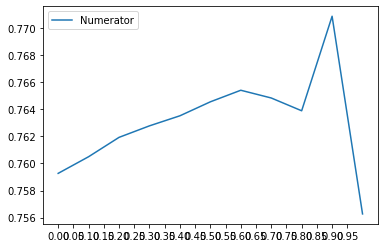

In [12]:
import matplotlib.pyplot as plt

loss = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
num = [0.7592709473199616, 0.7605003429974979, 0.7619300315045386, 0.7627806003100935, 0.7635230924156466, 0.7645549710917013, 0.765409892936603, 0.7648385119277056, 0.7638935402411391, 0.7708756158751785, 0.7562755523650166]
den = [0.9989264890185606, 1.0011894237360213, 1.0027469477894313, 1.0040469312581686, 1.0042344528366256, 1.004073511698654, 1.0038550432716364, 1.003434699416066, 1.002112866597193, 1.008204027229571, 0.9921484334419409]
ratio = [0.7600869089635823, 0.7595968604618574, 0.7598427830513205, 0.7597061218585223, 0.7603036225842978, 0.7614531826442227, 0.7624705360268715, 0.7622205135748167, 0.762282938083652, 0.7646027937355659, 0.7622604913474097]

plt.plot (loss, num, label = "Numerator")
plt.xticks(np.arange(min(loss), max(loss), 0.05))
plt.legend()
plt.show()


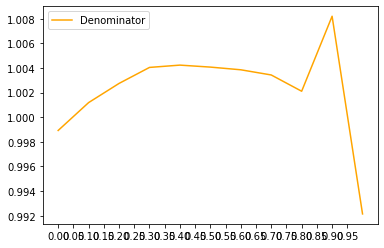

In [13]:
plt.plot (loss, den, label = "Denominator", color = "orange")
plt.xticks(np.arange(min(loss), max(loss), 0.05))
plt.legend()
plt.show()

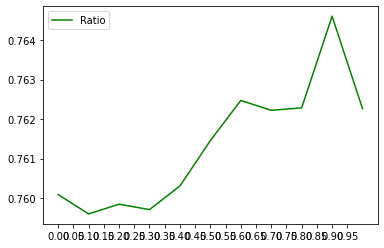

In [14]:
plt.plot (loss, ratio, label = "Ratio", color = "green")
plt.xticks(np.arange(min(loss), max(loss), 0.05))
plt.legend()
plt.show()

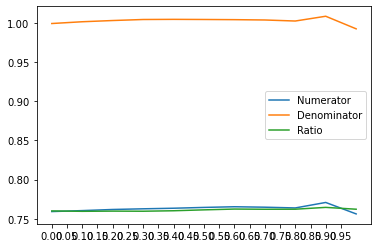

In [15]:
plt.plot (loss, num, label = "Numerator")
plt.plot (loss, den, label = "Denominator")
plt.plot (loss, ratio, label = "Ratio")
plt.xticks(np.arange(min(loss), max(loss), 0.05))
plt.legend()
plt.show()

In [16]:
# define NNPolicyLearner with IPW as its objective function
nn_ipw = NNPolicyLearner(
    n_actions=dataset.n_actions,
    dim_context=dataset.dim_context,
    off_policy_objective="ipw",
    batch_size=64,
    random_state=12345,
)
print(bandit_feedback_train["reward"] - 0)
print(bandit_feedback_train["reward"] - 0.5)

# train NNPolicyLearner on the training set of logged bandit data
nn_ipw.fit(
    context=bandit_feedback_train["context"],
    action=bandit_feedback_train["action"],
    reward=bandit_feedback_train["reward"],
    pscore=bandit_feedback_train["pscore"],
)
#MAKE A FOR LOOOP TO SUBTRACT LAMBDA FROM REWARD DIRECTLY??
#PUT LOSS_TRANSLATION AS A HYPERPARAMETER IN THE BEGINNING OF THE FILE??

# obtains action choice probabilities for the test set
action_dist_nn_ipw = nn_ipw.predict_proba(
    context=bandit_feedback_test["context"]
)
pred_actions = action_dist_nn_ipw [:,:,0]
action = bandit_feedback_test["action"]
idx_tensor = torch.arange(action.shape[0], dtype=torch.long)
pscore = bandit_feedback_test["pscore"]
rewards = bandit_feedback_test["reward"]

iw = pred_actions[idx_tensor, action] / pscore
numerator = np.mean(iw * rewards)
print(pred_actions[idx_tensor, action])
print(numerator)
# log_prob = torch.log(torch.from_numpy(action_dist_nn_ipw[:, :, 0]))

# current_pi = torch.from_numpy(action_dist_nn_ipw)
# iw = current_pi[idx_tensor, action]
# estimated_policy_grad_1 = iw * (rewards - 0.5)
# estimated_policy_grad_2 = iw * (rewards - 0.2)
# estimated_policy_grad_1 *= log_prob[idx_tensor, action]
# estimated_policy_grad_2 *= log_prob[idx_tensor, action]
# print(estimated_policy_grad_1, np.mean((estimated_policy_grad_1).numpy()))
# print(estimated_policy_grad_2, np.mean((estimated_policy_grad_2).numpy()))



#action = np.ndarray(np.amax(x) for x in pred_actions)
#print(action)

# current_pi = action_dist[:, :, 0].detach()
#log_prob = torch.log(action_dist[:, :, 0])
#idx_tensor = torch.arange(action.shape[0], dtype=torch.long) 
#iw = current_pi[idx_tensor, action] / pscore #here action is the index of max probabilities
#numerator = actions/pscore[:,pred_action]
#numerator = bandit_feedback_test["reward"] * (action_dist_nn_ipw)
#0.7592709473199616

policy learning:   0%|          | 0/200 [00:00<?, ?it/s]

[1 0 0 ... 0 0 1]
[ 0.5 -0.5 -0.5 ... -0.5 -0.5  0.5]
[1 0 0 ... 0 0 1]
[ 0.5 -0.5 -0.5 ... -0.5 -0.5  0.5]
Here


policy learning: 100%|██████████| 200/200 [01:06<00:00,  3.02it/s]

[3.5259037e-03 3.3378805e-05 3.3495526e-05 ... 3.2484073e-05 1.9276511e-05
 3.5286137e-06]
0.7592709473199616


In [17]:
# define NNPolicyLearner with DR as its objective function
nn_dr = NNPolicyLearner(
    n_actions=dataset.n_actions,
    dim_context=dataset.dim_context,
    off_policy_objective="dr",
    batch_size=64,
    random_state=12345,
)

# train NNPolicyLearner on the training set of logged bandit data
nn_dr.fit(
    context=bandit_feedback_train["context"],
    action=bandit_feedback_train["action"],
    reward=bandit_feedback_train["reward"],
    pscore=bandit_feedback_train["pscore"],
)

# obtains action choice probabilities for the test set
action_dist_nn_dr = nn_dr.predict_proba(
    context=bandit_feedback_test["context"]
)

policy learning:   0%|          | 0/200 [00:00<?, ?it/s]

[1 0 0 ... 0 0 1]
[ 0.5 -0.5 -0.5 ... -0.5 -0.5  0.5]
Here


policy learning: 100%|██████████| 200/200 [01:16<00:00,  2.61it/s]


In [18]:
# define IPWLearner with Logistic Regression as its base ML model
ipw_lr = IPWLearner(
    n_actions=dataset.n_actions,
    base_classifier=LogisticRegression(C=100, random_state=12345)
)

# train IPWLearner on the training set of logged bandit data
ipw_lr.fit(
    context=bandit_feedback_train["context"],
    action=bandit_feedback_train["action"],
    reward=bandit_feedback_train["reward"],
    pscore=bandit_feedback_train["pscore"]
)

# obtains action choice probabilities for the test set
action_dist_ipw_lr = ipw_lr.predict(
    context=bandit_feedback_test["context"]
)

In [19]:
# define IPWLearner with Random Forest as its base ML model
ipw_rf = IPWLearner(
    n_actions=dataset.n_actions,
    base_classifier=RandomForest(
        n_estimators=30, min_samples_leaf=10, random_state=12345
    )
)

# train IPWLearner on the training set of logged bandit data
ipw_rf.fit(
    context=bandit_feedback_train["context"],
    action=bandit_feedback_train["action"],
    reward=bandit_feedback_train["reward"],
    pscore=bandit_feedback_train["pscore"],
    l = 0
)

# obtains action choice probabilities for the test set
action_dist_ipw_rf = ipw_rf.predict(
    context=bandit_feedback_test["context"]
)

TypeError: fit() got an unexpected keyword argument 'l'

In [ ]:
# define Uniform Random Policy as a baseline evaluation policy
random = Random(n_actions=dataset.n_actions,)

# compute the action choice probabilities for the test set
action_dist_random = random.compute_batch_action_dist(
    n_rounds=bandit_feedback_test["n_rounds"]
)

In [ ]:
# action_dist is a probability distribution over actions (can be deterministic)
action_dist_ipw_lr[:, :, 0]

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 1., 0.]])

## (3) Evaluation of Off-Policy Learners
Our final step is the evaluation and comparison of the off-policy learners.

With synthetic data, we can calculate the policy value of the off-policy learners as follows. 

$$V(\pi_e) \approx \frac{1}{|\mathcal{D}_{te}|} \sum_{i=1}^{|\mathcal{D}_{te}|} \mathbb{E}_{a \sim \pi_e(a|x_i)} [q(x_i, a)], \; \, where \; \, q(x,a) := \mathbb{E}_{r \sim p(r|x,a)} [r]$$

where $\mathcal{D}_{te}$ is the test set of logged bandit data.

In [ ]:
# we calculate the policy values of the trained policies based on the expected rewards of the test data
policy_names = [
    "NN Policy Learner with DM",
    "NN Policy Learner with IPW",
    "NN Policy Learner with DR",
    "IPW Learner with Logistic Regression",
    "IPW Learner with Random Forest",
    "Unifrom Random"
]
action_dist_list = [
    action_dist_nn_dm,
    action_dist_nn_ipw,
    action_dist_nn_dr,
    action_dist_ipw_lr,
    action_dist_ipw_rf,
    action_dist_random
]

for name, action_dist in zip(policy_names, action_dist_list):
    true_policy_value = dataset.calc_ground_truth_policy_value(
        expected_reward=bandit_feedback_test["expected_reward"],
        action_dist=action_dist,
    )
    print(f'policy value of {name}: {true_policy_value}')

policy value of NN Policy Learner with DM: 0.7862505830999654
policy value of NN Policy Learner with IPW: 0.7606162025424541
policy value of NN Policy Learner with DR: 0.7732793867972861
policy value of IPW Learner with Logistic Regression: 0.7933299733929567
policy value of IPW Learner with Random Forest: 0.7050722711915117
policy value of Unifrom Random: 0.49992528545607745


In fact, `IPWLearner` with `LogisticRegression` seems to be the best in this simple setting.

We can iterate the above process several times to get more reliable results.

Please see [../examples/opl](../opl) for a more sophisticated example of the evaluation of off-policy learners with synthetic bandit data.